In [ ]:
import pandas as pd
import numpy as np
import os
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from xgboost import XGBClassifier
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
from hmmlearn.hmm import GaussianHMM
import umap.umap_ as umap
import shap

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Ellipse


print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/Python
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


In [5]:
df = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')


Summary descriptive statistics

In [6]:
list(df.columns)

['groupId',
 'playerId',
 'AwarenessMonitoringGrowth_aggregated_normGrowthMindset',
 'AwarenessMonitoringGrowth_aggregated_normSelfAwareness',
 'AwarenessMonitoringGrowth_aggregated_normSelfMonitoring',
 'AwarenessMonitoringGrowth_aggregated_rawGrowthMindset',
 'AwarenessMonitoringGrowth_aggregated_rawSelfAwareness',
 'AwarenessMonitoringGrowth_aggregated_rawSelfMonitoring',
 'AwarenessMonitoringGrowth_raw_canAdjust',
 'AwarenessMonitoringGrowth_raw_emotionalIntuition',
 'AwarenessMonitoringGrowth_raw_fixedIntelligence',
 'AwarenessMonitoringGrowth_raw_goingOnAroundMe',
 'AwarenessMonitoringGrowth_raw_innermostThoughts',
 'AwarenessMonitoringGrowth_raw_onlyLearnNewThings',
 'AwarenessMonitoringGrowth_raw_othersThinkOfMe',
 'AwarenessMonitoringGrowth_raw_tellInappropriate',
 'AwarenessMonitoringGrowth_raw_troubleChanging',
 'AwarenessMonitoringGrowth_time_seconds',
 'CulturalConflictNorms_aggregated_normConflictOpenness',
 'CulturalConflictNorms_aggregated_rawConflictOpenness',
 'Cultur

In [7]:
# Calculate the total number of participants
total_participants = df['playerId'].nunique()

# Calculate the total number of dyads (assuming dyads are represented by 'groupid')
total_dyads = df['groupId'].nunique()

# Calculate the gender breakdown
gender_counts = df['demographics_gender'].value_counts(normalize=True) * 100  # Percentage breakdown
male_percentage = gender_counts.get('male', 0.0)
female_percentage = gender_counts.get('female', 0.0)
unknown_percentage = gender_counts.get('', 0.0)

df['age'] = 2024 - df['demographics_birth_year']

# Calculate age statistics (mean and standard deviation)
mean_age = df['age'].mean()
std_age = df['age'].std()


print(f"Total participants: {total_participants}")
print(f"Total dyads: {total_dyads}")
print(f"Gender breakdown: {male_percentage:.1f}% male, {female_percentage:.1f}% female, {unknown_percentage:.1f}% unknown")
print(f"Mean age: {mean_age:.1f} years, SD: {std_age:.1f} years")

Total participants: 94
Total dyads: 47
Gender breakdown: 32.6% male, 67.4% female, 0.0% unknown
Mean age: 22.9 years, SD: 6.5 years


In [8]:
# For Agreement reached

subset = df[['groupId', 'deal_sheet_agreement_binary']]

group_counts = subset.groupby('groupId')['deal_sheet_agreement_binary'].value_counts().unstack(fill_value=0)

two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]

print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 43
Number of groupIds with 1 YES and 1 NO: 1
Number of groupIds with 2 NOs: 2


In [9]:
# For Trip reached

subset = df[['groupId', 'deal_sheet_trip_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_trip_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 39
Number of groupIds with 1 YES and 1 NO: 5
Number of groupIds with 2 NOs: 2


In [10]:
# For Return Fund reached

subset = df[['groupId', 'deal_sheet_return_fund_binary']]


group_counts = subset.groupby('groupId')['deal_sheet_return_fund_binary'].value_counts().unstack(fill_value=0)


two_yes = group_counts[(group_counts['Yes'] == 2) & (group_counts['No'] == 0)].shape[0]
one_yes_one_no = group_counts[(group_counts['Yes'] == 1) & (group_counts['No'] == 1)].shape[0]
two_nos = group_counts[(group_counts['Yes'] == 0) & (group_counts['No'] == 2)].shape[0]


print(f"Number of groupIds with 2 YES: {two_yes}")
print(f"Number of groupIds with 1 YES and 1 NO: {one_yes_one_no}")
print(f"Number of groupIds with 2 NOs: {two_nos}")

Number of groupIds with 2 YES: 25
Number of groupIds with 1 YES and 1 NO: 14
Number of groupIds with 2 NOs: 7


Divide negotiations into groups

In [11]:
# Clean Price Strings

def clean_price(text):
    """
    Cleans a raw text input representing a monetary value and extracts
    the most relevant numeric amount. Handles formats like:
    - "$275,000"
    - "275k"
    - "275,000 for 75%"
    - "USD 150k"
    Returns the first valid integer value found, or None if not parseable.
    """
    if pd.isna(text):
        return None

    # Normalize text: remove currency symbols and standardize casing
    text = text.lower().replace(',', '').replace('$', '').replace('usd', '').strip()

    # Convert shorthand (e.g., '150k') to full value (e.g., '150000')
    text = re.sub(r'(\d+)\s*k', lambda m: str(int(m.group(1)) * 1000), text)

    # Look for 5-digit or longer numbers (most likely dollar amounts)
    numbers = re.findall(r'\d{5,}', text)

    # Fallback: look for 4-digit numbers if no large ones are found
    if not numbers:
        numbers = re.findall(r'\d{4,}', text)

    # Return the first match, converted to integer
    return int(numbers[0]) if numbers else None


# Calculate Satisfaction Scores

def calculate_satisfaction(final, role):
    """
    Returns a satisfaction score based on role expectations:
    - For Star Scientist: 
        -1 if < $355k, 
         0 if = $355k, 
         positive if > $355k
    - For Provost:
        -1 if > $275k,
         0 if = $275k,
         positive if < $275k
    """
    if pd.isna(final) or pd.isna(role):
        return None

    final = float(final)

    if role.lower() == "star scientist":
        min_accept = 355000
        if final < min_accept:
            return -1
        elif final == min_accept:
            return 0
        else:
            return np.clip((final - min_accept) / min_accept, 0, 1)

    elif role.lower() == "provost":
        max_accept = 275000
        if final > max_accept:
            return -1
        elif final == max_accept:
            return 0
        else:
            return np.clip((max_accept - final) / max_accept, 0, 1)

    return None  # Unknown role

def categorize_negotiation_score(min_score, max_score):
    """
    Categorizes negotiation outcomes and assigns a score on a balanced -3 to +3 scale.

    Outcome Categories:
    --------------------
    +3 = Mutually beneficial
         - Both parties exceeded their minimum thresholds (both satisfaction > 0)
         - A rare, true win-win with surplus value for both

    +1 = Asymmetrical win
         - One party exceeded their threshold (score > 0)
         - The other just met their minimum acceptable (score == 0)
         - An unbalanced deal, but both parties got something they can accept

    0  = Mutual compromise
         - Both parties just hit their threshold (score == 0)
         - A stable but neutral agreement; no surplus for either side

    -1 = Asymmetrical loss
         - One party failed to meet their minimum (score == -1)
         - The other met or exceeded theirs (score >= 0)
         - A fragile or coercive deal — someone walked away feeling they lost

    -3 = Mutual loss
         - Both parties failed to meet their minimum thresholds (score == -1)
         - Likely a breakdown or forced agreement with no acceptable outcome

    """
    if min_score > 0 and max_score > 0:
        return "Mutually beneficial", 3
    elif (min_score == 0 and max_score > 0) or (min_score > 0 and max_score == 0):
        return "Asymmetrical win", 1
    elif min_score == 0 and max_score == 0:
        return "Mutual compromise", 0
    elif min_score == -1 and max_score >= 0:
        return "Asymmetrical loss", -1
    elif min_score == -1 and max_score == -1:
        return "Mutual loss", -3
    else:
        return "Uncategorized", None



In [12]:
outcome_df = df[['groupId', 'playerId','role',
    'deal_sheet_agreement_binary', 'deal_sheet_trip_binary', 'deal_sheet_return_fund_binary',
    'pre_negotiation_target_price', 'deal_sheet_deal_price']]



# Clean final deal price
outcome_df["final_price_clean"] = outcome_df["deal_sheet_deal_price"].apply(clean_price)

# Normalize role labels
outcome_df["role"] = outcome_df["role"].str.strip().str.lower()

# Calculate satisfaction for each party
outcome_df["satisfaction"] = outcome_df.apply(
    lambda row: calculate_satisfaction(row["final_price_clean"], row["role"]),
    axis=1
)

# Group by negotiation and calculate min/max satisfaction
group_outcome = outcome_df.groupby("groupId").agg(
    min_score=("satisfaction", "min"),
    max_score=("satisfaction", "max")
)

# Assign outcome category and success score
group_outcome[["negotiation_outcome_category", "negotiation_success_score"]] = group_outcome.apply(
    lambda row: pd.Series(categorize_negotiation_score(row["min_score"], row["max_score"])),
    axis=1
)

# Keep only final output columns
group_outcome = group_outcome[["negotiation_outcome_category", "negotiation_success_score"]].reset_index()

group_outcome.value_counts('negotiation_outcome_category')

/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_12663/4146702944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df["final_price_clean"] = outcome_df["deal_sheet_deal_price"].apply(clean_price)
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_12663/4146702944.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df["role"] = outcome_df["role"].str.strip().str.lower()
/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_12663/4146702944.py:14: SettingWithCopyWarn

negotiation_outcome_category
Asymmetrical loss    39
Mutual loss           4
Mutual compromise     2
Asymmetrical win      1
Uncategorized         1
Name: count, dtype: int64

In [13]:
group_outcome[group_outcome["negotiation_outcome_category"].isin(["Mutual loss", "Asymmetrical win"])]

,groupId,negotiation_outcome_category,negotiation_success_score
0,01HYGGKFHG8BZ3KW7ZDR0KGC4N,Mutual loss,-3.0
5,01HYGGPM8PPG1XP0ZX8JQH9BHH,Mutual loss,-3.0
14,01HYGGS2EPNP03PM16W01GW0BF,Mutual loss,-3.0
20,01HYGGTWRDB265ZDQV4ZTR126E,Mutual loss,-3.0
31,01HYGGX90QVABM7YXJDC9W4J66,Asymmetrical win,1.0


In [14]:
# Calculate Task Conflict and Relationship Conflict for each group
df['Task_Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2']].mean(axis=1)
df['Relationship_Conflict'] = df[['post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)
df['Conflict'] = df[['post_negotiation_conflict_1', 'post_negotiation_conflict_2','post_negotiation_conflict_3', 'post_negotiation_conflict_4']].mean(axis=1)
df['team_viability'] = df[['post_negotiation_viability_1', 'post_negotiation_viability_2']].mean(axis=1)

df = df[['groupId', 'Task_Conflict', 'Relationship_Conflict', 'Conflict', 'team_viability']]
df = df.groupby('groupId', as_index=False).mean()
 

In [16]:
# Compute means
mean_conflict = df['Conflict'].mean()
mean_viability = df['team_viability'].mean()

# classification function to classify negotiations using rules based aproach
def classify_negotiation(conflict, viability, mean_conf, mean_viab):
    if conflict < mean_conf and viability > mean_viab:
        return "Friendly"
    elif conflict >= mean_conf and viability > mean_viab:
        return "Constructive"
    elif conflict < mean_conf and viability <= mean_viab:
        return "Apathetic"
    else:
        return "Destructive"
    
# Apply classification
df["Negotiation_Category"] = df.apply(
    lambda row: classify_negotiation(row['Conflict'], row['team_viability'], mean_conflict, mean_viability), axis=1
)

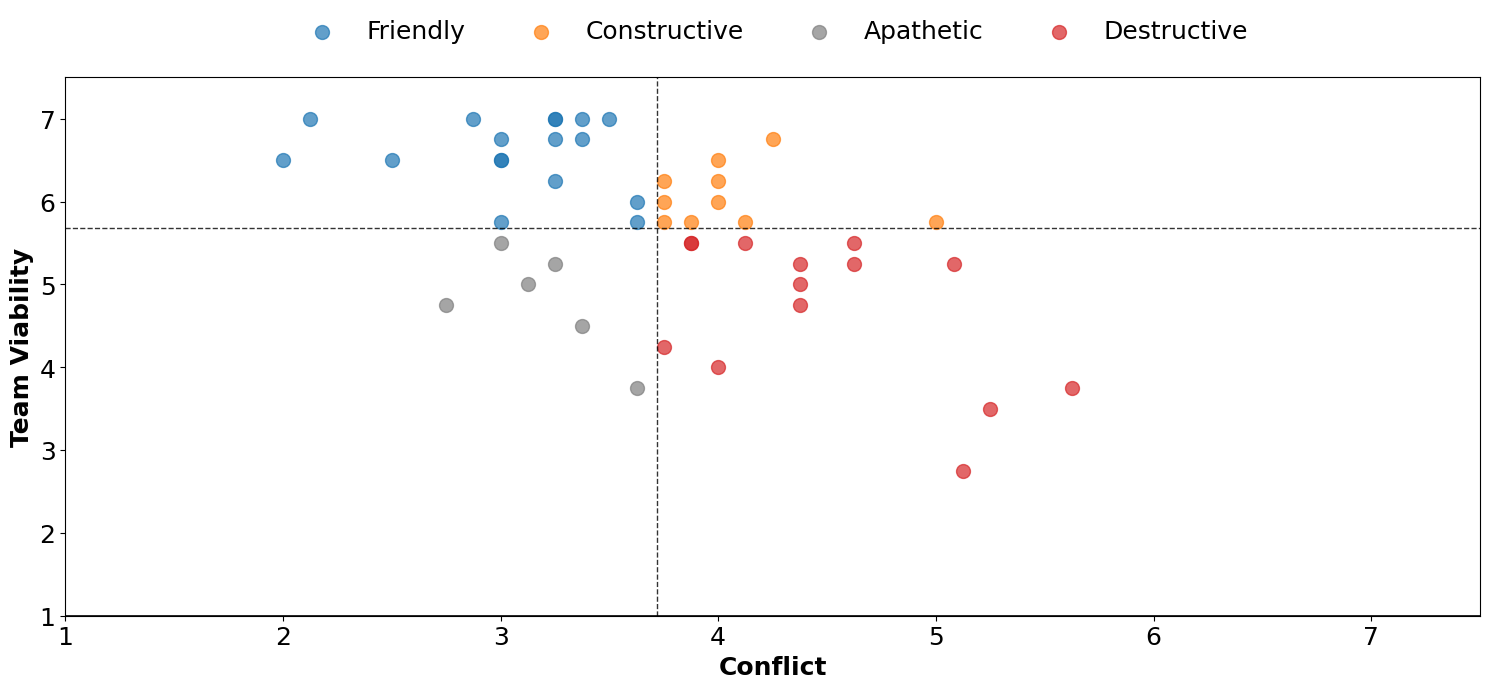

In [18]:
# Plot the classification

# Define colors for each category
category_colors = {
    "Friendly": "#1F77B4",  # Blue
    "Constructive": "#FF7F0E",  # Orange
    "Apathetic": "#7F7F7F",  # Gray
    "Destructive": "#D62728"  # Red
}

# Create the scatter plot
plt.figure(figsize=(15, 7))

# Plot data points with category colors
for category, color in category_colors.items():
    subset = df[df["Negotiation_Category"] == category]
    plt.scatter(subset['Conflict'], subset['team_viability'], label=category, color=color, alpha=0.7, s=100)

# Add decision boundaries (mean values)
plt.axvline(mean_conflict, color="black", linestyle="dashed", alpha=0.8, linewidth=1)
plt.axhline(mean_viability, color="black", linestyle="dashed", alpha=0.8, linewidth=1)

# Formatting plot aesthetics
plt.xlabel("Conflict", fontsize=18, fontweight="bold")
plt.ylabel("Team Viability", fontsize=18, fontweight="bold")


# Legend styling (placed at the top with extra spacing)
plt.legend(fontsize=18,
           loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False)

# Ensure full axis range is visible
plt.xlim(1, 7.5)
plt.ylim(1, 7.5)

# Restore axis lines for a professional look
plt.axhline(y=plt.ylim()[0], color='black', linewidth=1.2)
plt.axvline(x=plt.xlim()[0], color='black', linewidth=1.2)

# Remove grid lines
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
correlation, p_value = stats.pearsonr(df['Conflict'], df['team_viability'])

print(f"Pearson Correlation Coefficient: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")

Pearson Correlation Coefficient: -0.57
P-Value: 0.0000


**Load transcript data, merge and identify behaviours in each category**

In [20]:
df_features = pd.read_csv('./Output/super_May22/multimodal_data.csv')
df_features = df_features.dropna()
dvs = df.copy()

print(df_features.shape)
print(dvs.shape)

(4740, 230)
(47, 6)


In [21]:
# df_features = pd.read_csv('./Output/super_May22/multimodal_data.csv')
# dvs = df.copy()

# Extract the last 6 characters from PairID and groupId
df_features['MergeKey'] = df_features['PairID'].str[-6:]
dvs['MergeKey'] = dvs['groupId'].str[-6:]

dvs = dvs[['MergeKey', 'Negotiation_Category', 'Conflict', 'team_viability']]
# Perform a left join
merged_data = df_features.merge(dvs, on='MergeKey', how='left')

# Drop the temporary MergeKey column if not needed
merged_data.drop(columns=['MergeKey'])

merged_data.to_clipboard()

In [22]:
# Load the file
mmdata_LUT = pd.read_csv('./Output/super_May22/mmdata_LUT.csv')

# Clean up variable names in the 'variables' column of mmdata_LUT
mmdata_LUT['variable'] = mmdata_LUT['variable'].str.replace('_lexical_wordcount', '', regex=False)
mmdata_LUT['variable'] = mmdata_LUT['variable'].str.replace('_receptiveness_yeomans', '', regex=False)

# Clean up variable names in the columns of merged_data
merged_data.columns = merged_data.columns.str.replace('_lexical_wordcount', '', regex=False)
merged_data.columns = merged_data.columns.str.replace('_receptiveness_yeomans', '', regex=False)

# Display the cleaned data
# print(mmdata_LUT.head())
# print(merged_data.head())

In [23]:
mm_data = merged_data[['Pair_Speaker_turn',
 'PairID',
 'PersonID',
 'Speaker',
 'Speaker_original',
 'Turn',
 'Word',
 'StartTime',
 'EndTime',
 'Backchannel',
 'Overlap',
 'Contested',
 'Duration',
 'Negotiation_Category',
 'Conflict',
 'team_viability',
 'Sentiment',
 'word_count']]


In [24]:
mm_data

,Pair_Speaker_turn,PairID,PersonID,Speaker,Speaker_original,Turn,Word,StartTime,EndTime,Backchannel,Overlap,Contested,Duration,Negotiation_Category,Conflict,team_viability,Sentiment,word_count
0,20240521_1823_WBLMay0KGC4N_B_B_1,20240521_1823_WBLMay0KGC4N,1716394507208-76380b8e-8d97-41f0-94d7-727c6867...,B,B,1,hello,0.758041,0.997423,0.0,0.0,0.0,0.239381,Destructive,5.125,2.75,0.00,1
1,20240521_1823_WBLMay0KGC4N_A_A_2,20240521_1823_WBLMay0KGC4N,1716394507208-35c603e4-2275-4f7b-a2bb-c2333fa0...,A,A,2,hello,2.189815,2.508333,0.0,0.0,0.0,0.318519,Destructive,5.125,2.75,0.00,1
2,20240521_1823_WBLMay0KGC4N_B_B_3,20240521_1823_WBLMay0KGC4N,1716394507208-76380b8e-8d97-41f0-94d7-727c6867...,B,B,3,can you hear me,3.072062,3.630618,0.0,0.0,0.0,0.558556,Destructive,5.125,2.75,0.00,4
3,20240521_1823_WBLMay0KGC4N_A_A_4,20240521_1823_WBLMay0KGC4N,1716394507208-35c603e4-2275-4f7b-a2bb-c2333fa0...,A,A,4,yes,4.339815,4.578704,0.0,0.0,0.0,0.238889,Destructive,5.125,2.75,0.00,1
4,20240521_1823_WBLMay0KGC4N_B_B_5,20240521_1823_WBLMay0KGC4N,1716394507208-76380b8e-8d97-41f0-94d7-727c6867...,B,B,5,okay great so thank you so much for taking the...,5.386082,24.779910,0.0,0.0,0.0,19.393828,Destructive,5.125,2.75,0.39,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,20240522_1325_S3WBLMZ0SDTF_Both_A_85,20240522_1325_S3WBLMZ0SDTF,1716395873575-7db9651b-6ff3-4ef0-a4a5-6ff39541...,Both,A,85,yes please,1751.572500,1752.050300,0.0,0.5,1.0,0.477800,Destructive,4.125,5.50,0.00,2
4736,20240522_1325_S3WBLMZ0SDTF_A_A_86,20240522_1325_S3WBLMZ0SDTF,1716395873575-7db9651b-6ff3-4ef0-a4a5-6ff39541...,A,A,86,okay i like that i like that would i,1785.918500,1792.885000,0.0,0.0,0.0,6.966500,Destructive,4.125,5.50,0.50,9
4737,20240522_1325_S3WBLMZ0SDTF_Both_B_86,20240522_1325_S3WBLMZ0SDTF,1716395873575-dbc8c255-cadf-4975-a424-81e58c47...,Both,B,86,three,1792.691300,1792.851200,0.0,1.0,1.0,0.159900,Destructive,4.125,5.50,0.00,1
4738,20240522_1325_S3WBLMZ0SDTF_B_B_87,20240522_1325_S3WBLMZ0SDTF,1716395873575-dbc8c255-cadf-4975-a424-81e58c47...,B,B,87,seconds left by the way,1792.851200,1793.810400,0.0,0.0,0.0,0.959200,Destructive,4.125,5.50,0.00,5


In [26]:
# Get the list of columns to include from mmdata_LUT
columns_to_include = mmdata_LUT['variable'].tolist()

# Ensure the columns exist in merged_data before selecting them
columns_to_include = [col for col in columns_to_include if col in merged_data.columns]

# Extend mm_data with the selected columns
mm_data = mm_data.join(merged_data[columns_to_include])

In [27]:
list(mm_data.columns)

['Pair_Speaker_turn',
 'PairID',
 'PersonID',
 'Speaker',
 'Speaker_original',
 'Turn',
 'Word',
 'StartTime',
 'EndTime',
 'Backchannel',
 'Overlap',
 'Contested',
 'Duration',
 'Negotiation_Category',
 'Conflict',
 'team_viability',
 'Sentiment',
 'word_count',
 'Acknowledgement',
 'Affirmation',
 'Agreement',
 'Apology',
 'Ask_Agency',
 'By_The_Way',
 'Can_You',
 'Conjunction_Start',
 'Could_You',
 'Disagreement',
 'Filler_Pause',
 'First_Person_Plural',
 'First_Person_Single',
 'For_Me',
 'For_You',
 'Formal_Title',
 'Give_Agency',
 'Goodbye',
 'Gratitude',
 'Hedges',
 'Hello',
 'Impersonal_Pronoun',
 'Informal_Title',
 'Let_Me_Know',
 'Negation',
 'Negative_Emotion',
 'Please',
 'Positive_Emotion',
 'Reasoning',
 'Reassurance',
 'Second_Person',
 'Subjectivity',
 'Swearing',
 'Truth_Intensifier',
 'Bare_Command',
 'YesNo_Questions',
 'WH_Questions',
 'Adverb_Limiter',
 'Token_count',
 'Pitch',
 'Loudness',
 'Pulse',
 'Speech_crispiness',
 'Speech_brightness',
 'Frequency_spread',


Hierarchichal Dimensionality Reduction

In [28]:
# Identify Modality Groups
linguistic_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Text']['variable'].tolist()
vocal_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Vocal']['variable'].tolist()
facial_vars = mmdata_LUT[mmdata_LUT['modality'] == 'Facial']['variable'].tolist()

# Preprocessing
# Keep Linguistic Features Unchanged
linguistic_df = mm_data[linguistic_vars].copy()

# Function to aggregate highly correlated features
def aggregate_correlated_features(data, threshold=0.5):
    corr_matrix = data.corr()
    groups = []
    seen = set()
    mapping = {}
    
    for feature in data.columns:
        if feature not in seen:
            correlated = corr_matrix[feature][(corr_matrix[feature] > threshold) & (corr_matrix[feature] < 1.0)].index.tolist()
            if correlated:
                group = [feature] + correlated
                groups.append(group)
                seen.update(group)
            else:
                groups.append([feature])
                seen.add(feature)
    
    aggregated_data = pd.DataFrame()
    for group in groups:
        if len(group) > 1:  # Only create an aggregated feature if there are at least two original features
            common_prefix = group[0].split('_')[0]  # Extract common prefix from first feature
            group_name = f"Agg_{common_prefix}"
            aggregated_data[group_name] = data[group].mean(axis=1)
            mapping[group_name] = group  # Store mapping
        else:
            # Keep single features unchanged
            single_feature = group[0]
            aggregated_data[single_feature] = data[single_feature]
            mapping[single_feature] = [single_feature]
    
    return aggregated_data, mapping

# Aggregate Vocal and Facial Features Based on Correlation
scaler = MinMaxScaler()
mm_data[vocal_vars] = scaler.fit_transform(mm_data[vocal_vars])
mm_data[facial_vars] = scaler.fit_transform(mm_data[facial_vars])

vocal_df, vocal_mapping = aggregate_correlated_features(mm_data[vocal_vars])
facial_df, facial_mapping = aggregate_correlated_features(mm_data[facial_vars])

# Save the feature mapping to a CSV file for user review
mapping_df = pd.DataFrame({
    "New Feature Name": list(vocal_mapping.keys()) + list(facial_mapping.keys()),
    "Original Features": [", ".join(vocal_mapping[key]) for key in vocal_mapping] + [", ".join(facial_mapping[key]) for key in facial_mapping]
})

mapping_df.to_csv("feature_mapping_review.csv", index=False)
print("Feature mapping saved as feature_mapping.csv. Please review and update names before proceeding.")


Feature mapping saved as feature_mapping.csv. Please review and update names before proceeding.


In [29]:
# Step 1: Load the reviewed feature mapping
typed_feature_mapping = pd.read_csv("./Output/super_May22/feature_mapping_review.csv")

# Step 2: Extract lists of original vocal and facial features
original_vocal_facial_features = []
feature_groups = {}

for _, row in typed_feature_mapping.iterrows():
    new_feature_name = row["New Feature Name"]
    original_features_list = row["Original Features"].split(", ")  # Ensure list format
    original_vocal_facial_features.extend(original_features_list)
    feature_groups[new_feature_name] = original_features_list
    
# Step 3: Create a subset of df with only vocal and facial features
vocal_facial_df = mm_data[original_vocal_facial_features].copy()

# Step 4: Aggregate the variables based on mapping and keep only the new features
new_vocal_facial_df = pd.DataFrame()
for new_feature, original_features in feature_groups.items():
    new_vocal_facial_df[new_feature] = vocal_facial_df[original_features].mean(axis=1)
    
# Step 5: Remove all original vocal and facial features from df
updated_df = mm_data.drop(columns=original_vocal_facial_features)

# Step 6: Append the new variables to updated_df
updated_df = pd.concat([updated_df, new_vocal_facial_df], axis=1)

# Save the final dataset
final_csv_filename = "./Output/super_May22/mm_data_agg.csv"
updated_df.to_csv(final_csv_filename, index=False)
print(f"Final dataset saved as {final_csv_filename}. New feature names applied.")

Final dataset saved as ./Output/super_May22/mm_data_agg.csv. New feature names applied.
